## DataRobot Python API Training

Notebook #2 - Model Factory

raul.arrabales@datarobot.com

More examples of model factory implementations: [DataRobot Community Github](https://github.com/datarobot-community/tutorials-for-data-scientists/tree/master/Model%20Factories)

### Building a Predictive Model Factory

#### Activity Goal

In this activity, you will practice building a model factory that trains models to predict the odds that a hospital patient with diabetes will be readmitted to the hospital after discharge.

First you will create a single model based on the entire dataset. Then you will implement a model factory that segments the data based on the original admission type (emergency, elective, etc.) and trains different models for each segment.

The data used in this activity is extracted from the original dataset [https://www.hindawi.com/journals/bmri/2014/781670/](here).
Citation: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records", BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014. https://doi.org/10.1155/2014/781670

**Libraries**

In [3]:
import datarobot as dr  # Requires version >2.25
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle

C:\Users\array\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
C:\Users\array\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


**Lib Config**

In [4]:
sns.set(style="whitegrid")

**Data Sets**

In [5]:
# url_to_data = "https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes.csv" 
# url_to_scoring_data = 'https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes_scoring.csv'
training_data = pd.read_csv('implementing-model-factories-211013\\10k_diabetes.csv')
training_data.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,...,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,...,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,...,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,...,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,...,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis


**Connect to DataRobot**

In [6]:
credentials_File = 'drconfig.yaml'

dr.Client(config_path=credentials_File)

#### Define Plotting Functions
These functions will be used to plot the ROC curve and Feature Impact to compare generated models.

In [7]:
def plot_roc_curve(datarobot_model):
    """This function plots a roc curve.
    Input:
        datarobot_model: <Datarobot Model object>
    """
    roc = datarobot_model.get_roc_curve('crossValidation')
    roc_df = pd.DataFrame(roc.roc_points)
    auc_score = datarobot_model.metrics['AUC']['crossValidation']
    plt.plot(roc_df['false_positive_rate'], roc_df['true_positive_rate'], 'b', label = 'AUC = %0.2f' %auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_feature_impact(datarobot_model, title=None):
    """This function plots feature impact
    Input:
        datarobot_model: <Datarobot Model object>
        title : <string> --> title of graph
    """
    # Get feature impact
    feature_impacts = datarobot_model.get_or_request_feature_impact()

    # Sort feature impact based on normalised impact
    feature_impacts.sort(key=lambda x: x['impactNormalized'], reverse=True)

    fi_df = pd.DataFrame(feature_impacts) #Save feature impact in pandas dataframe
    fig, ax = plt.subplots(figsize=(14,5))
    b = sns.barplot(x="featureName", y="impactNormalized", data=fi_df[0:5], color="b")
    b.axes.set_title('Feature Impact' if not title else title,fontsize=20)

#### Train a single model based on the entire dataset

##### Start a project based on the full readmission dataset

In [8]:
full_dataset_project_name = f'Readmission_{datetime.datetime.now()}'                 

full_dataset_project = dr.Project.create(training_data,                    
                                project_name=full_dataset_project_name)

full_dataset_project.set_target(target='readmitted', worker_count=-1)                     

# Wait for autopilot to finish (this can take quite a long time)
log = full_dataset_project.wait_for_autopilot() 

In progress: 12, queued: 0 (waited: 0s)
In progress: 12, queued: 0 (waited: 1s)
In progress: 12, queued: 0 (waited: 2s)
In progress: 12, queued: 0 (waited: 3s)
In progress: 12, queued: 0 (waited: 4s)
In progress: 12, queued: 0 (waited: 6s)
In progress: 12, queued: 0 (waited: 10s)
In progress: 12, queued: 0 (waited: 17s)
In progress: 12, queued: 0 (waited: 31s)
In progress: 12, queued: 0 (waited: 51s)
In progress: 3, queued: 0 (waited: 73s)
In progress: 1, queued: 0 (waited: 93s)
In progress: 7, queued: 0 (waited: 114s)
In progress: 7, queued: 0 (waited: 134s)
In progress: 5, queued: 0 (waited: 155s)
In progress: 2, queued: 0 (waited: 176s)
In progress: 16, queued: 0 (waited: 196s)
In progress: 14, queued: 0 (waited: 217s)
In progress: 3, queued: 0 (waited: 238s)
In progress: 0, queued: 0 (waited: 258s)
In progress: 0, queued: 0 (waited: 279s)
In progress: 0, queued: 0 (waited: 299s)
In progress: 5, queued: 0 (waited: 320s)
In progress: 5, queued: 0 (waited: 340s)
In progress: 1, queued

#### Review recommended model

In [9]:
recommended_model = full_dataset_project.recommended_model()

print(recommended_model) 
print(recommended_model.metrics['LogLoss']['crossValidation']) # Print crossValidation score

Model('Light Gradient Boosted Trees Classifier with Early Stopping')
0.60455


##### Visualize the ROC Curve and Feature Impact

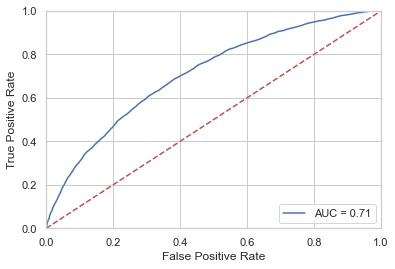

In [10]:
plot_roc_curve(recommended_model)

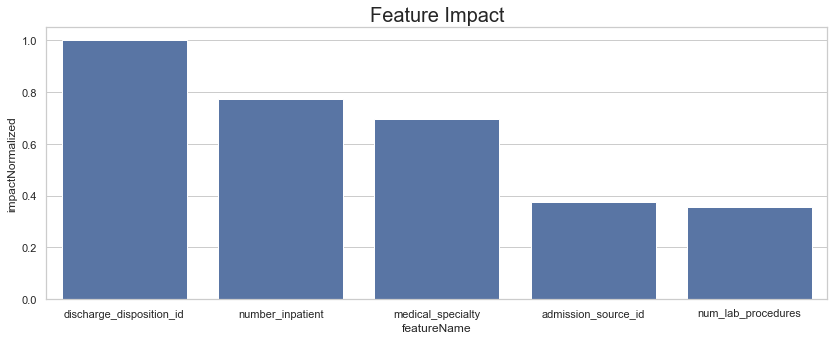

In [11]:
plot_feature_impact(recommended_model)

#### Create a Model Factory for segmented modeling

Admission type can be used as a segmentation key in order to create multiple projects. Using a Model Factory to generate the projects will allow you to compare the segmented models to the full-dataset model to see if it improves accuracy. 

##### Train a model for each admission type

In [12]:
# Dictionary to save projects by admission type

projects = {} 

# Loop through all of the admission types in the dataset
# Start a project for each

admission_types = training_data.admission_type_id.unique()

for admission_type in admission_types:
    
    # define project name based on admission date and current timestamp
    project_name = f'Readmission_{admission_type}_{datetime.datetime.now()}'

    print(f'Starting project {project_name}')
    try:
        # select rows in the dataframe with the current admission type
        data_by_admission_type = training_data.loc[training_data['admission_type_id'] == admission_type]
        data_by_admission_type.head()
        # start a project 
        temp_project = dr.Project.create(data_by_admission_type,
                                        project_name = project_name)
        temp_project.set_target(target = 'readmitted', worker_count = -1)
        projects[admission_type] = temp_project
    except: # Catch the case where dataset has fewer than 20 rows.
        pass

Starting project Readmission_Elective_2022-04-28 17:25:53.796666
Starting project Readmission_Urgent_2022-04-28 17:28:05.728237
Starting project Readmission_Not Available_2022-04-28 17:30:08.448157
Starting project Readmission_Emergency_2022-04-28 17:32:04.608074
Starting project Readmission_nan_2022-04-28 17:34:06.840564
Starting project Readmission_Not Mapped_2022-04-28 17:34:33.698451
Starting project Readmission_Newborn_2022-04-28 17:35:23.676452


In [13]:
# Wait for all models to complete
for admission_type in projects:
     log = projects[admission_type].wait_for_autopilot()

In progress: 1, queued: 0 (waited: 0s)
In progress: 1, queued: 0 (waited: 1s)
In progress: 1, queued: 0 (waited: 2s)
In progress: 1, queued: 0 (waited: 2s)
In progress: 1, queued: 0 (waited: 4s)
In progress: 1, queued: 0 (waited: 6s)
In progress: 1, queued: 0 (waited: 10s)
In progress: 1, queued: 0 (waited: 17s)
In progress: 1, queued: 0 (waited: 30s)
In progress: 1, queued: 0 (waited: 51s)
In progress: 1, queued: 0 (waited: 71s)
In progress: 0, queued: 0 (waited: 92s)
In progress: 0, queued: 0 (waited: 112s)
In progress: 0, queued: 0 (waited: 133s)
In progress: 0, queued: 0 (waited: 154s)
In progress: 0, queued: 0 (waited: 174s)
In progress: 1, queued: 0 (waited: 0s)
In progress: 1, queued: 0 (waited: 1s)
In progress: 1, queued: 0 (waited: 1s)
In progress: 1, queued: 0 (waited: 2s)
In progress: 1, queued: 0 (waited: 4s)
In progress: 1, queued: 0 (waited: 6s)
In progress: 1, queued: 0 (waited: 10s)
In progress: 1, queued: 0 (waited: 17s)
In progress: 1, queued: 0 (waited: 31s)
In progr

In [14]:
# For convenience, save project info
pickle.dump(projects, open("save_readmission_projects.pickle", "wb" ) )

# You can use the saved dictionary later to reload the projects and models if you
# restart your notebook.
# projects = pickle.load(open("save_readmission_projects.pickle", "rb" ) )
projects

{'Elective': Project(Readmission_Elective_2022-04-28 17:25:53.796666),
 'Urgent': Project(Readmission_Urgent_2022-04-28 17:28:05.728237),
 'Not Available': Project(Readmission_Not Available_2022-04-28 17:30:08.448157),
 'Emergency': Project(Readmission_Emergency_2022-04-28 17:32:04.608074)}

##### Show the recommended model for each admission category
Compare the cross validation scores for the segmented models to the score for the full dataset model you displayed earlier.

In [15]:
recommended_models = {}

for admission_type, project in projects.items():
    recommended_model = project.recommended_model()
    recommended_models[admission_type] = recommended_model
    print('--------------------------------')
    print(f'Recommended model for admission type id: {admission_type}')
    print(recommended_model)
    print(f"Cross validation: {recommended_model.metrics['LogLoss']['crossValidation']}")
    print('--------------------------------')

--------------------------------
Recommended model for admission type id: Elective
Model('Elastic-Net Classifier (L2 / Binomial Deviance)')
Cross validation: 0.6216019999999999
--------------------------------
--------------------------------
Recommended model for admission type id: Urgent
Model('eXtreme Gradient Boosted Trees Classifier')
Cross validation: 0.594056
--------------------------------
--------------------------------
Recommended model for admission type id: Not Available
Model('Elastic-Net Classifier (L2 / Binomial Deviance)')
Cross validation: 0.611394
--------------------------------
--------------------------------
Recommended model for admission type id: Emergency
Model('Generalized Additive2 Model')
Cross validation: 0.620636
--------------------------------


##### Compare feature impact for admission types

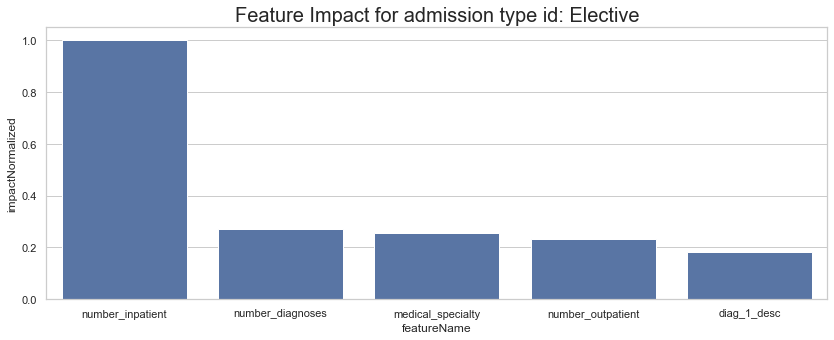

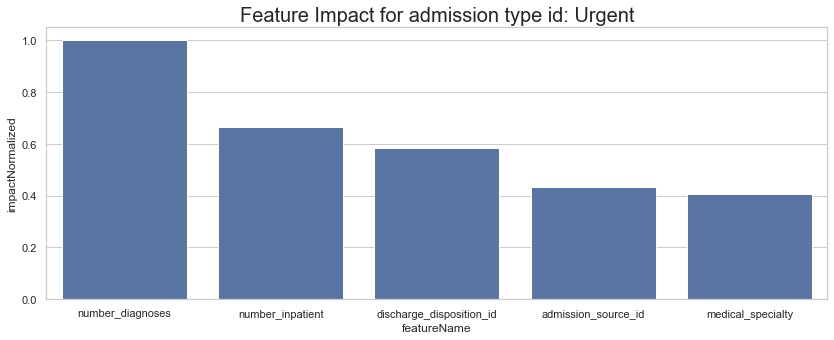

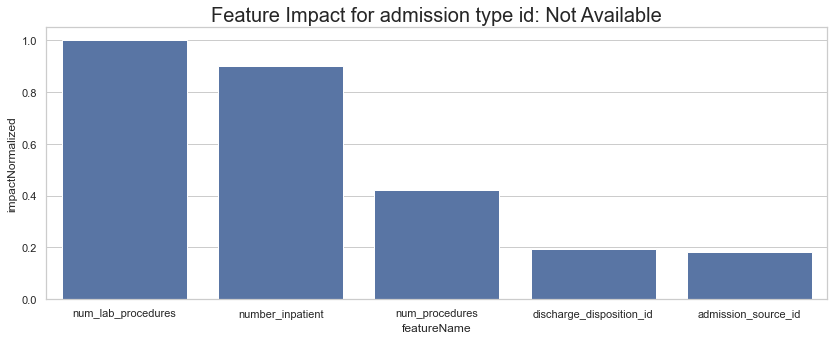

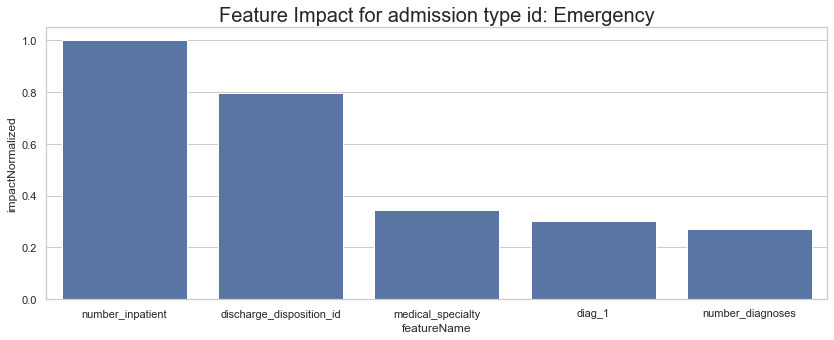

In [16]:
for admission_type in projects:
    plot_feature_impact(recommended_models[admission_type], title ='Feature Impact for admission type id: %s' %admission_type)

#### Deploying the models
Deploy the models so that you can test making segmented prediction requests.

Note that you should not pass the `default_prediction_server_id` if you are using a trial or pay-as-you-go account.

In [17]:
deployments={}

prediction_server = dr.PredictionServer.list()[0] # comment out if using trial or pay-as-you-go

for admission_type in recommended_models:
    deployments[admission_type] = dr.Deployment.create_from_learning_model(
                                    recommended_models[admission_type].id, 
                                    label='Readmissions_admission_type: %s' %admission_type,
                                    description='Test deployment',
                                    default_prediction_server_id=prediction_server.id # comment out if using trial or pay-as-you-go
                                  )


In [18]:
# For convenience, save deployment info
pickle.dump(deployments, open("save_readmission_deployments.pickle", "wb" ) )

# You can use the saved dictionary later to reload the deployment IDs if you
# restart your notebook.
# deployments = pickle.load(open("save_readmission_deployments.pickle", "rb" ) )

#### Request predictions

Direct prediction requests to the correct model deployment based on admission type ID.

In [19]:
# load data to score
test_data = pd.read_csv('implementing-model-factories-211013\\readmission-scoring.csv')

# Save batch prediction job info
jobs={}

# Get a list of admission types in the scoring dataset
admission_types = test_data.admission_type_id.unique()

for admission_type in admission_types:

    # create DataFrame for just current admission type data
    test_data_by_admission_type = test_data.loc[test_data['admission_type_id'] == admission_type]
          
    # Start a batch prediction job for the current admission type segment of data 
    output_file = f"readmission-predictions-{admission_type}.csv"
    print(f'Scoring {admission_type} to {output_file}')

    job = dr.BatchPredictionJob.score (
        deployment=deployments[admission_type].id,
        passthrough_columns=['id'],
        intake_settings={
           'type': 'localFile',
           'file': test_data_by_admission_type,
        },
        output_settings={
            'type': 'localFile',
            'path': output_file
        }
    )
    jobs[admission_type] = job
    
for admission_type,job in jobs.items():
    job.wait_for_completion()
    print(f'{admission_type} complete')

Scoring Emergency to readmission-predictions-Emergency.csv
Scoring Urgent to readmission-predictions-Urgent.csv
Scoring Elective to readmission-predictions-Elective.csv
Emergency complete
Urgent complete
Elective complete
